In [1]:
# Análisis histórico de movimientos bancarios
# Septiembre–Octubre 2025
# ==========================================

import pandas as pd
from pathlib import Path

In [2]:
# --- 1. Configuración de rutas ---
carpeta_datos = Path("../datos_brutos")
archivos = [carpeta_datos / "cartola.xls", carpeta_datos / "cartola (1).xls"]

In [3]:
# --- 2. Función para limpiar cada archivo ---
def limpiar_cartola(ruta_archivo, fecha_inicio, fecha_fin):
    """Lee y limpia un archivo .xls descargado del banco."""
    df = pd.read_excel(ruta_archivo, skiprows=26, usecols="B:G")
    df.columns = ["fecha", "descripcion", "canal", "cargos", "abonos", "saldo"]
    df = df.dropna(subset=["fecha", "descripcion"], how="all")
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")

    # Filtrar el rango exacto de fechas
    df = df[(df["fecha"] >= fecha_inicio) & (df["fecha"] <= fecha_fin)]

    # Reemplazar NaN por 0 en cargos y abonos
    df["cargos"] = df["cargos"].fillna(0)
    df["abonos"] = df["abonos"].fillna(0)

    return df

In [4]:
# --- 3. Limpiar archivos por mes ---
df_sep = limpiar_cartola(archivos[0], "2025-09-01", "2025-09-30")
df_oct = limpiar_cartola(archivos[1], "2025-10-01", "2025-10-31")

In [5]:
# --- 4. Unir ambos meses ---
df_hist = pd.concat([df_sep, df_oct]).sort_values("fecha").reset_index(drop=True)

In [8]:
# --- 5. Guardar archivo consolidado ---
ruta_salida = Path(r"C:\Dev\\Python\\finanzas\\datos_procesados\\historico.csv")
df_hist.to_csv(ruta_salida, index=False, encoding="utf-8-sig")

print(f"Archivo histórico guardado en: {ruta_salida}")

Archivo histórico guardado en: C:\Dev\Python\finanzas\datos_procesados\historico.csv


In [10]:
# --- 6. Análisis básico ---
df_hist["mes"] = df_hist["fecha"].dt.to_period("M")

# Totales por mes
resumen_mensual = df_hist.groupby("mes").agg({
    "cargos": "sum",
    "abonos": "sum"
}).reset_index()

resumen_mensual["balance_neto"] = resumen_mensual["abonos"] - resumen_mensual["cargos"]

print("\nResumen mensual (CLP):")
print(resumen_mensual)


Resumen mensual (CLP):
       mes     cargos     abonos  balance_neto
0  2025-09  3602169.0  3938361.0      336192.0
1  2025-10  2847247.0  2442536.0     -404711.0


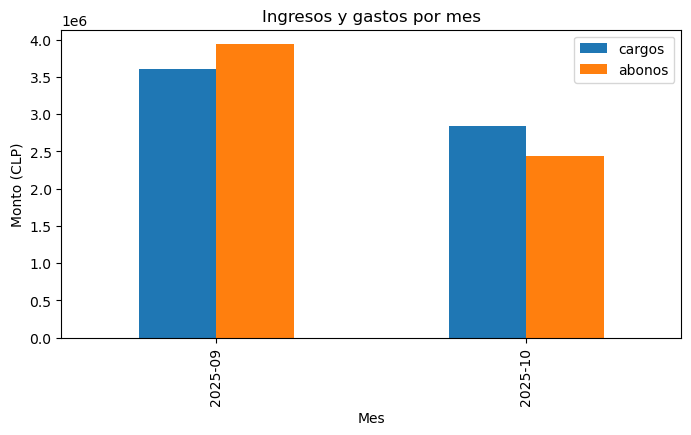

In [11]:
# --- 7. Visualización básica ---
import matplotlib.pyplot as plt

resumen_mensual.set_index("mes")[["cargos", "abonos"]].plot(kind="bar", figsize=(8,4))
plt.title("Ingresos y gastos por mes")
plt.ylabel("Monto (CLP)")
plt.xlabel("Mes")
plt.show()

In [16]:
# Balance promedio y tendencia mensual
# --- 2️⃣ Principales descripciones de gasto (extendido) ---
# Filtramos solo transacciones con cargos (gastos reales)
gastos = df_hist[df_hist["cargos"] > 0]

# Contamos cuántas veces aparece cada descripción
gastos_top = gastos["descripcion"].value_counts().head(50)

# Mostramos más filas para observar mejor los patrones
pd.set_option("display.max_rows", 50)
print("\nPrincipales conceptos de gasto (top 50):\n")
print(gastos_top)


Principales conceptos de gasto (top 50):

descripcion
Pago:sumup * Licoreria                  10
Traspaso A:Sociedad Comercial Alt        4
Pago:salcobrand Jose                     4
Pago:tuu*almaboulder                     3
Cargo Por Pago Tc                        3
Pago:huertofer                           3
Traspaso A:Ivan Leiva Vera               2
Pago:mercadopago*joser                   2
Pago:gimnasio Casa Bou                   2
Traspaso A:Pablo Raimundo Guarda         2
Pago:merpago*bastian                     2
Pago:hotel Ritz Ritual                   2
Cargo Seguro Proteccion Bancaria         2
Pago:entel Oneclick Pc                   2
Traspaso A:Felipe Guarda                 2
Pago:payscan*snack Cen                   2
Pago:patagonia Aliment                   2
Traspaso A:Maria Pulgar                  2
Traspaso A:Valeria Gonzalez Paine        2
Pago:comercial Pamela                    2
Pago:restobar V P Spa                    2
Giro Cajero Automatico             *     1

In [ ]:
# ============================================
# Clasificación de gastos según regla 50/30/20
# ============================================

# Diccionario de palabras clave
# Puedes ajustar o ampliar según tus propios movimientos
reglas = {
    "necesidades": [
        "arriendo", "supermercado", "líder", "jumbo", "unimarc", "tottus",
        "santa isabel", "mercado", "panadería", "farmacia", "cruz verde",
        "ahumada", "colun", "cuenta", "agua", "luz", "electricidad", "gas",
        "metrogas", "internet", "entel", "vtr", "claro", "movistar",
        "telefonía", "colegio", "transporte", "bencina", "servipag",
        "tarjeta bip", "micro", "peaje", "isapre", "fonasa", "seguro",
        "impuesto", "patente", "salud", "Sociedad Comercial Alt", "salcobrand"
    ],
    "gustos": [
        "restaurante", "bar", "Licoreria", "cerveza", "café", "starbucks", "juan valdez",
        "mcdonald", "burguer", "pizza", "comida", "delivery", "rappi",
        "ubereats", "netflix", "spotify", "amazon", "youtube", "hbo",
        "cine", "concert", "teatro", "viaje", "aerolinea", "jetsmart",
        "latam", "despegar", "ropa", "zara", "nike", "adidas",
        "falabella", "paris", "ripley", "deporte", "trekking", "escapada",
        "feria", "música", "libro", "regalo"
    ],
    "ahorros": [
        "ahorro", "depósito", "fondo", "mutuo", "apv", "cuenta vista",
        "transferencia propia", "inversión", "notransfer", "bolsa",
        "cuenta2", "emergencia"
    ]
}

# Función para clasificar una descripción
def clasificar_gasto(descripcion):
    desc = str(descripcion).lower()
    for categoria, palabras in reglas.items():
        if any(p in desc for p in palabras):
            return categoria
    return "otro"

# Aplicar la clasificación al DataFrame
df_hist["categoria"] = df_hist["descripcion"].apply(clasificar_gasto)

# Resumen de montos por categoría
resumen_cat = df_hist.groupby("categoria")["cargos"].sum().sort_values(ascending=False)
porcentajes = (resumen_cat / df_hist["cargos"].sum() * 100).round(1)

print("\nDistribución de gastos por categoría:")
print(pd.DataFrame({"Monto (CLP)": resumen_cat, "Porcentaje (%)": porcentajes}))


In [13]:
# Principales descripciones de gasto
gastos = df_hist[df_hist["cargos"] > 0]
gastos_top = gastos["descripcion"].value_counts().head(15)
print("\nPrincipales conceptos de gasto:\n", gastos_top)



Principales conceptos de gasto:
 descripcion
Pago:sumup * Licoreria               10
Traspaso A:Sociedad Comercial Alt     4
Pago:salcobrand Jose                  4
Pago:tuu*almaboulder                  3
Cargo Por Pago Tc                     3
Pago:huertofer                        3
Traspaso A:Ivan Leiva Vera            2
Pago:mercadopago*joser                2
Pago:gimnasio Casa Bou                2
Traspaso A:Pablo Raimundo Guarda      2
Pago:merpago*bastian                  2
Pago:hotel Ritz Ritual                2
Cargo Seguro Proteccion Bancaria      2
Pago:entel Oneclick Pc                2
Traspaso A:Felipe Guarda              2
Name: count, dtype: int64


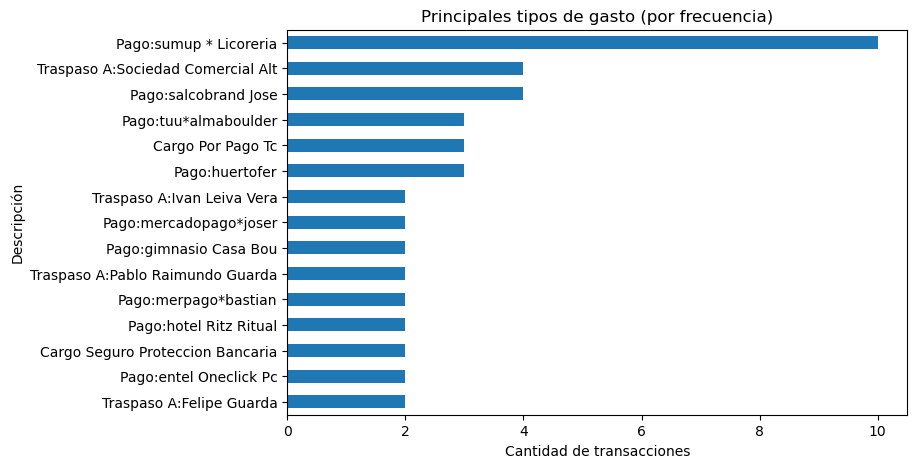

In [14]:
import matplotlib.pyplot as plt

gastos_top.plot(kind="barh", figsize=(8,5))
plt.title("Principales tipos de gasto (por frecuencia)")
plt.xlabel("Cantidad de transacciones")
plt.ylabel("Descripción")
plt.gca().invert_yaxis()
plt.show()


In [19]:
# Cálculo de distribución mensual 50/30/20
# con subdivisión del 20% de ahorro
# ================================================

# Ingreso mensual (ajusta según tus ingresos reales)
ingreso_mensual = 2_300_000  # CLP

# Distribución porcentual
porcentajes = {
    "necesidades": 0.50,
    "gustos": 0.30,
    "ahorro_total": 0.20,
    "ahorro_reserva": 0.10,       # dentro del 20%
    "ahorro_objetivo": 0.10       # dentro del 20%
}

# Cálculo de montos
distribucion = {
    "necesidades": ingreso_mensual * porcentajes["necesidades"],
    "gustos": ingreso_mensual * porcentajes["gustos"],
    "ahorro_reserva": ingreso_mensual * porcentajes["ahorro_reserva"],
    "ahorro_objetivo": ingreso_mensual * porcentajes["ahorro_objetivo"]
}

# Mostrar resultados
import pandas as pd

tabla = pd.DataFrame.from_dict(distribucion, orient="index", columns=["Monto (CLP)"])
tabla["Monto (CLP)"] = tabla["Monto (CLP)"].astype(int)
print("\nDistribución recomendada para ingreso mensual de $2.300.000 CLP:\n")
print(tabla)

# Validar suma
print(f"\nTotal verificado: ${int(tabla['Monto (CLP)'].sum()):,} CLP")


Distribución recomendada para ingreso mensual de $2.300.000 CLP:

                 Monto (CLP)
necesidades          1150000
gustos                690000
ahorro_reserva        230000
ahorro_objetivo       230000

Total verificado: $2,300,000 CLP
